<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Adolescent_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adolescent Group Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls

### Load path_config.py 
- we are already in the source/group_svm directory so we can just load this file without changing directories

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import plot_alphas
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics, get_roi_bmaps
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

#Part I:
      Perform subject splitting into Young Adults
      Load saved pre-processed data from AWS 
                - or -
      Apply mask to .MAT data and filter data by labels
      Transform Data by:
          - Scaling data per run per subject based on normalization type (Z-score, Percent Signal Change or No Normalization)
          - Detrend the time series per run per subject
          - Concatenate the Training and Test Data (We can apply a Validation set but not needed since we performed Cross Validation on the Validation set prior for model tuning)
          - Train sklearn.svm.SVC with Params: C: 10; gamma: 'auto', class_balanced, and max_iter = 1000
          - Collect metrics: Accuracies, probabilities, classification report
          and save into a dictionary and uploading to S3. 

#### If you wish to skip ahead, please jump to **Part II** where we can load in the metrics data to visualize the brain data. Performance metric visualization is performed in a separate notebook called **Group_analysis.ipynb** in this current directory.  

### Load Unmasked Data from AWS 
- normalize and transform data
- and obtain Adolescent subjects from first 33 subject IDs

In [ ]:
%%time
# Get mat file 
mask_type = 'masksubmPFC' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels'
from_mat = 'unnorm' #unnorm
data_type = "AD_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Adolescent
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 
     
if statement == False:
  print(f"Masking mat data to {mask_type}...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind)
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

## SVM Adolescent
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [ ]:
# get train, test val data
train_ids = ad[:26]
#val_ids = ad[23:28]
test_ids = ad[26:33]

group_sub_ids = (train_ids, False, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = False
runs_test = [1,2] #2 # grabds the third run
znorm = "Detrend_Znorm" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization


print("Number of Adolescent training examples: ", len(train_ids))
print(train_ids)
#print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(test_ids)
print(len(ad))

model_dict = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, znorm, data_type, m_path_ind)

#Part II:
## Visualization Analysis
      Load saved metrics for a given brain mask and extract 
      bmap 
      y labels 
      alpha values 

      If we are loading in the whole brain mask, we will also load in mask
      indices for regions of interest in which we want to apply as a mask
      overlay on top of the whole brain data. This will visually block out all
      areas of the brain other than the region of interest we wish to
      highlight. 
      
      - Plot the brain mask data using Nilearn's plot_img package
      - Visualize the decision function time series with y labels
      - Visualize a histogram of that represents essentially the decision
        function by plotting where voxels are in the positive or negative class
        and highlights the data where they have been mislabeled.
      - Save plots locally

**Creating the bmaps** 
        
        
      - We find the support vectors and indices from our model
        using .support_ and the weights of our model using 
        .dual_coef_. 
      - We create a dummy 3D image in the shape of our X   
        train data and store our weights in this matrix but
        only at the significant indices where our support
        vectors were found. This is what we call our alpha  
        matrix. 
      - Take the dot product of the alpha matrix (support
        vector weights) and the X train matrix. This is what we
        call our beta matrix. 
      - Then we map this matrix full of values back to the 
        original brain space of (79,95,79) using the indices of 
        our applied mask. 
      - There are many steps of reshaping the data in these 
        steps and the results were double checked on MATLAB 
        software to ensure accurate mapping. 
      - The final beta matrix is then converted to a NIFTI file 
        for use with the Nilearn image package.

In [4]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "AD_detrend"
runs_train = [1, 2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key
metric_data = access_load_data(f'metrics/group_svm/{mask_type}/{data_type}_{runs_id}_{mask_type}_metrics.pkl', False)
print(metric_data.keys())

dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


#### Load Beta map for Visualization
- Create/load Alphas and Bmaps for Region of Interest
          We will look at:
            - Whole Brain Mask
            - medial Prefrontal Cortex
            - Nucleus Accumbens

In [5]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)


> Whole Brain Interactive Voxel Map


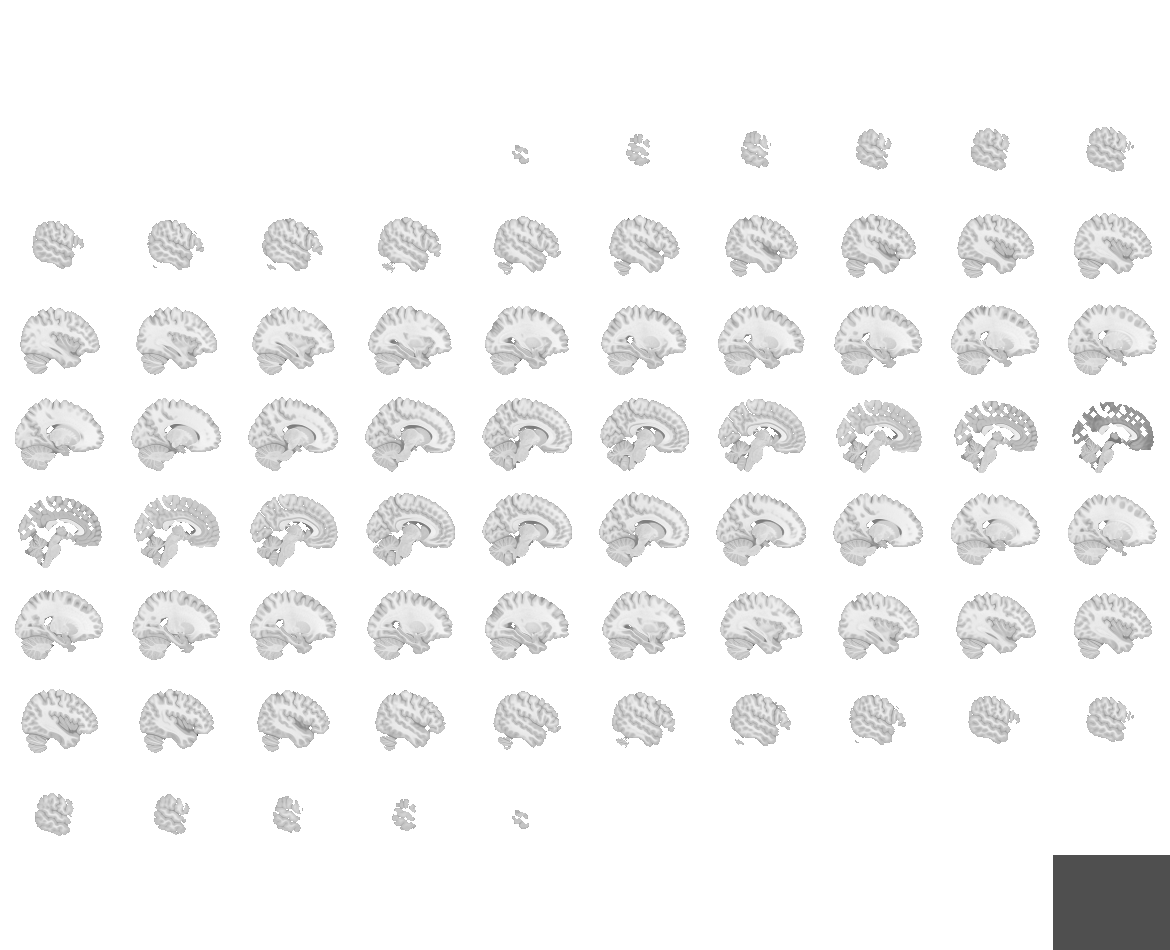
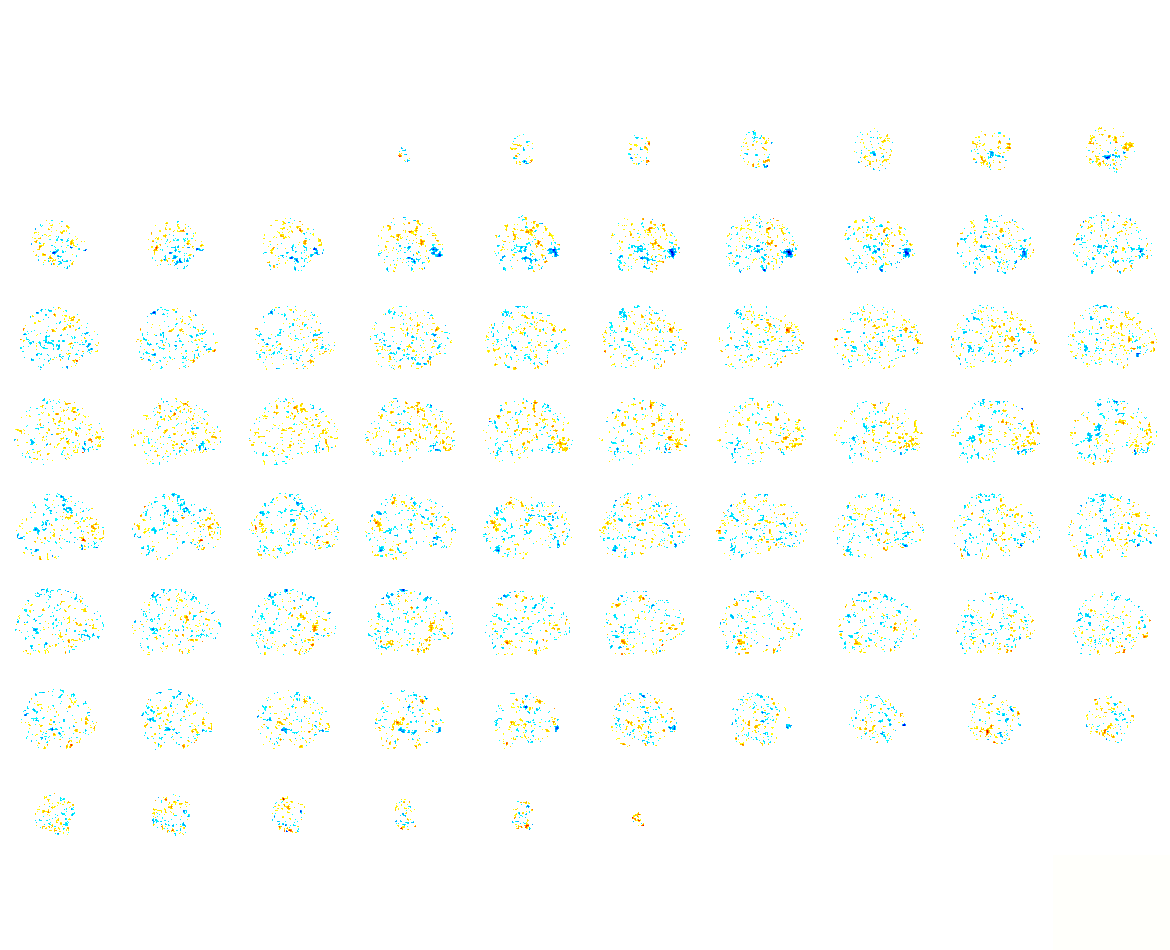

In [8]:
# Plot interactive maps     
html_view = plotting.view_img(metric_data['bmap3'][0], 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=(4, -78, 20),#[-10, 13, -8],
                              black_bg = False,
                              title=f"Adolescent Whole Brain")#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_1.html')

> Isolating the Medial Prefrontal Cortex Region of Interest using data trained on whole brain

mask shape: (79, 95, 79)



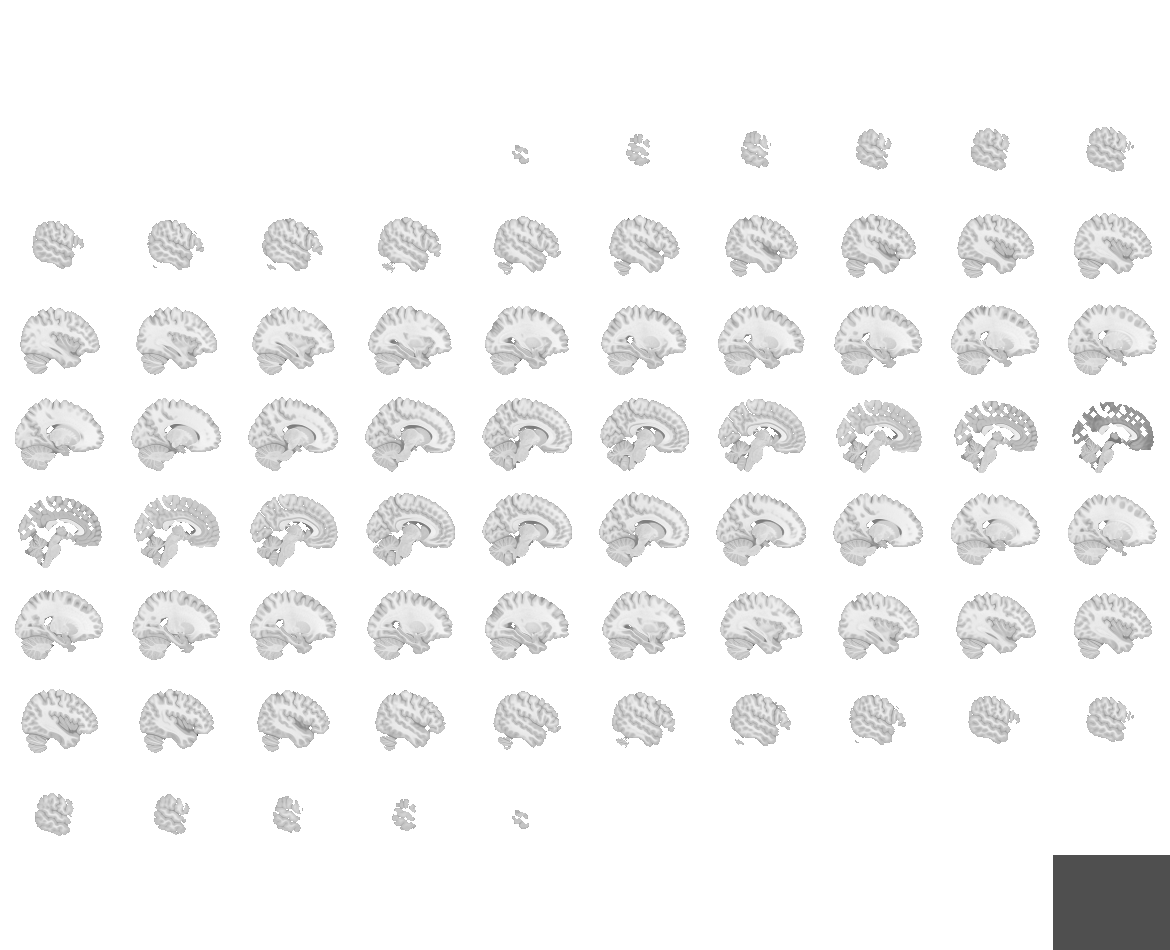
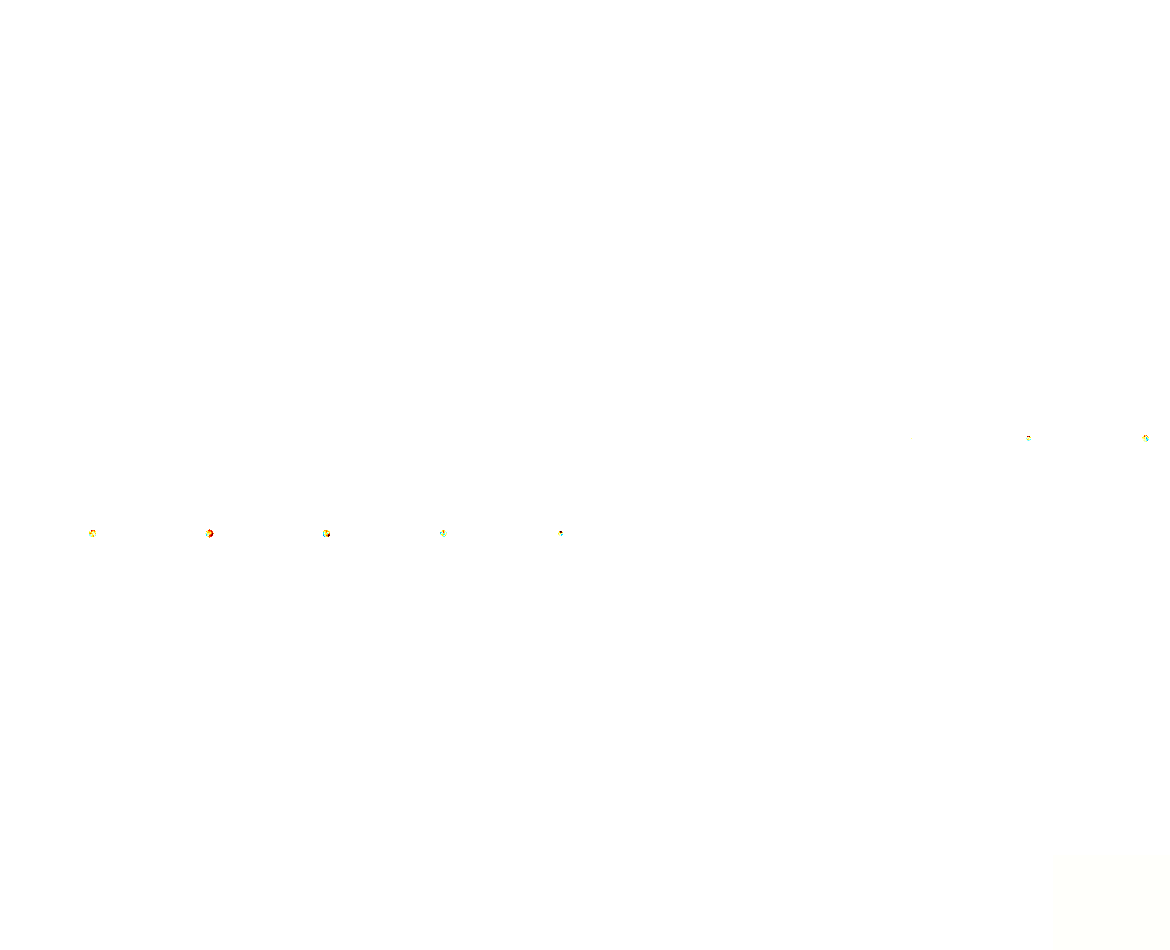

In [13]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'mPFC' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3pfc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3pfc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              title=f"Adolescent Medial PFC",
                              resampling_interpolationst = 'continuous'
                              )#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_roi}_1.html')

> Isolate the Nucleus Accumbens in Whole Brain data

mask shape: (79, 95, 79)



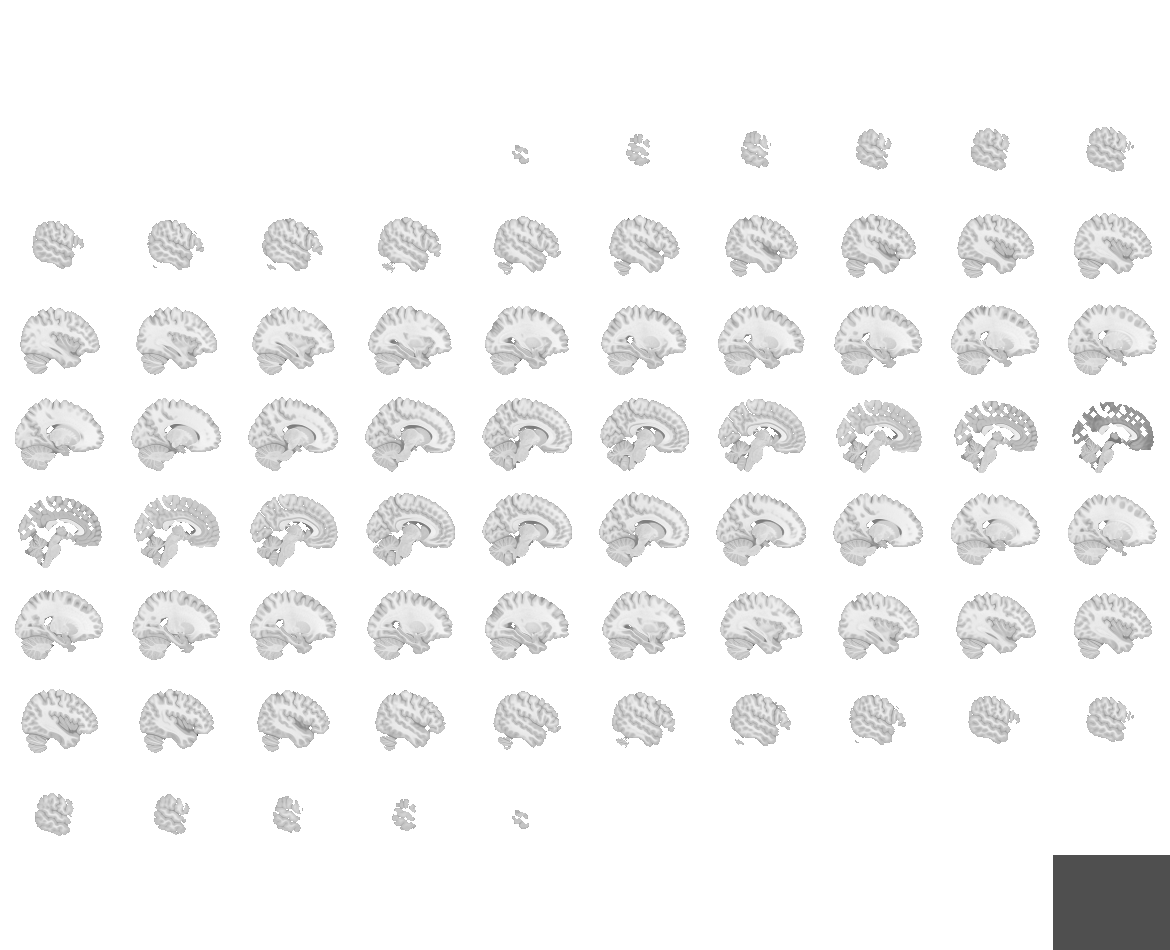
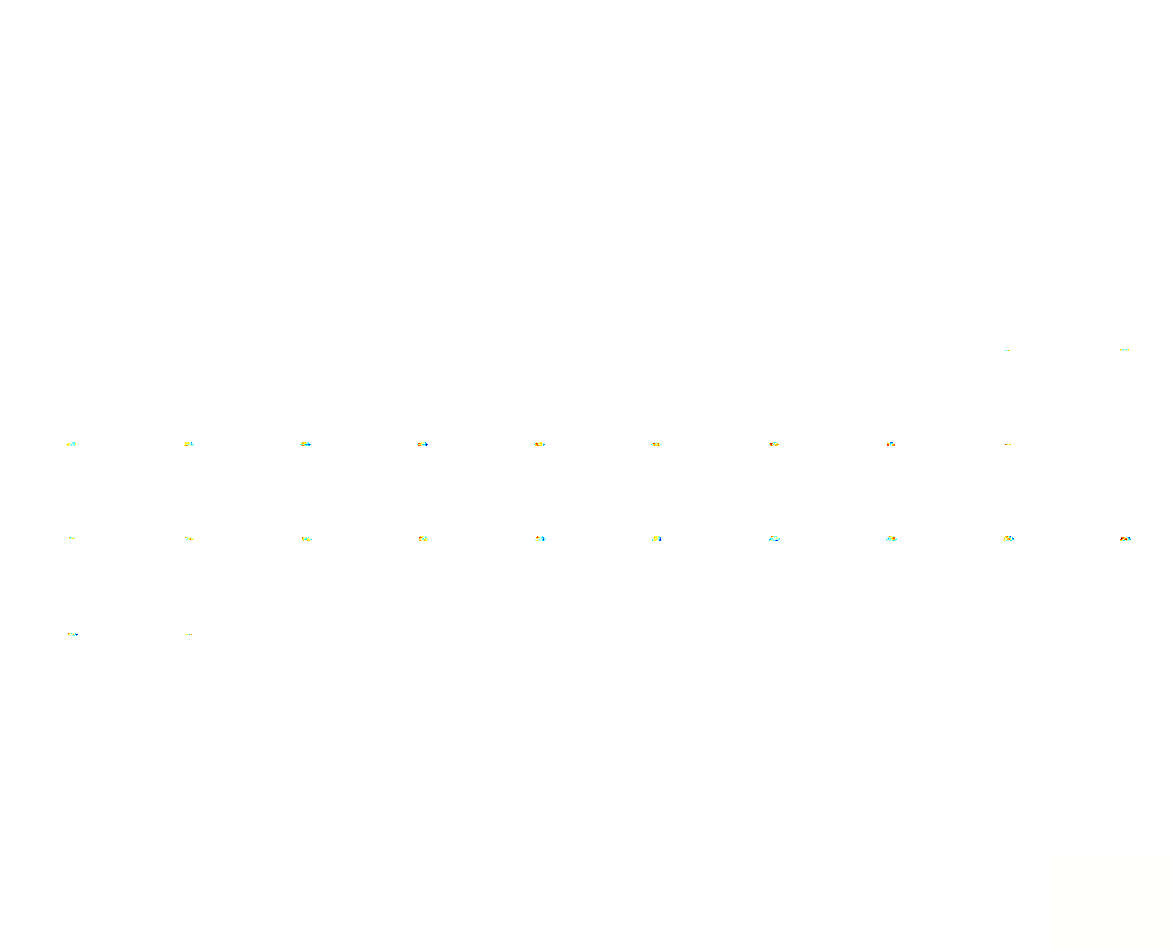

In [16]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'nacc_aal' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3nacc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3nacc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              black_bg = False,
                              title=f"Adolescent NAcc"
                              )#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_roi}_1.html')

> Let's Plot Whole Brain Slices 

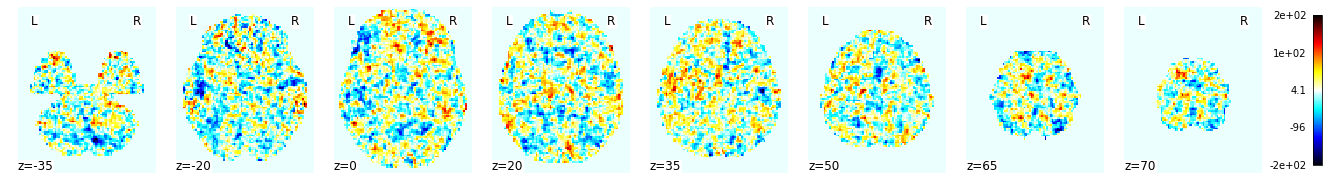

In [19]:
# View Slices of the brain
# get bmaps for visualization
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "AD_detrend"
msk_type = 'Whole Brain'
bmap3 = metric_data['bmap3'][0]

outfile = True

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_plt_z_1.png"

  title = f"Young Adult {msk_type}"
  im = plotting.plot_img(bmap3, 
                          #bg_img = t1_image,
                          #title = title,
                          colorbar=True, 
                          black_bg = False, 
                          cut_coords = (-35,-20,0,20,35,50,65,70),
                          cmap='cold_white_hot', 
                          display_mode='z',
                          #output_file = output_file
                          )
  """im.title(title, 
          x=0.01, 
          y=0.99, 
          size=15, 
          color='black', 
          bgcolor='w'
          )"""

> Plot Whole Brain with Thresholds
  - Score Percentile threshold 
  - Image Intensity threshold

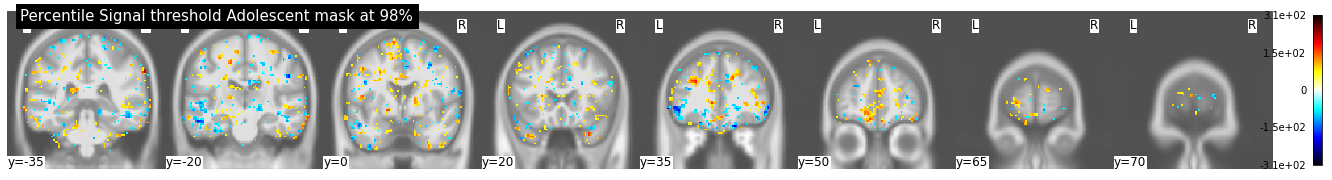

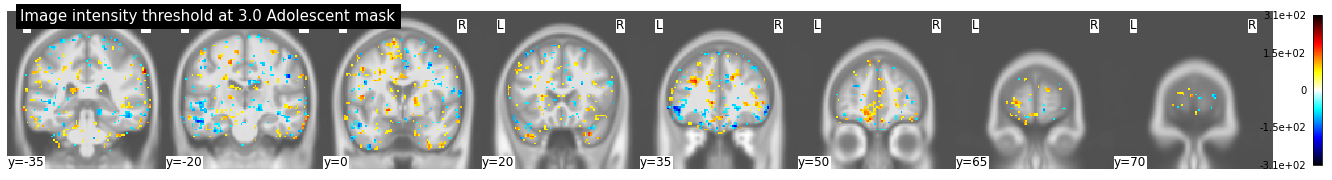

In [23]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = True
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Adolescent {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Adolescent {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_stat_map(threshold_percentile_img,
                        title = title2 ,
                        bg_img = t1_image, 
                        display_mode='y', 
                        black_bg = False, 
                        cut_coords= (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        #annotate = False,
                        cmap = "cold_white_hot",
                        #output_file=output_file1
                       )

# Showing intensity threshold image
im3 = plotting.plot_stat_map(threshold_value_img, 
                        title = title3,
                        bg_img = t1_image, 
                        black_bg = False, 
                        display_mode='y', 
                        cut_coords= (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        #output_file=output_file2
                       )

> Plot X, Y, Z Slice to Highlight a large area of activation in the data. The Visual Cortex has been shown to be significant in the task fMRI. Further analysis might include masking out the visual cortex prior to model training. 

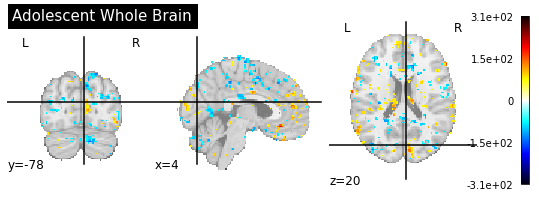

In [25]:
# Plotting all slices in brain
title = f'Adolescent Whole Brain'
output_file3 = f"/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_xyz.png"
plotting.plot_stat_map(bmap3, #threshold_percentile_img, 
                       #bg_img = t1_image, 
                       #display_mode='z', 
                       cut_coords=(4, -78, 20), 
                       annotate = True,
                       title=title, 
                       colorbar=True,
                       black_bg = False,
                       cmap = "cold_white_hot",
                       #output_file=output_file3
                       )

> Plot Alphas and Decision Function values

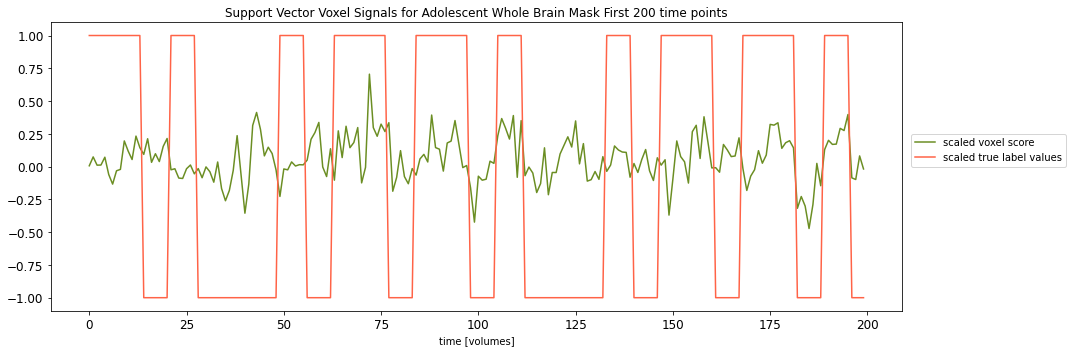

In [27]:
# Create a DataFrame from metrics of Whole Brain
decision_scores = metric_data['test_dfunc'][0]
y = metric_data['y_t'][0]
alpha = metric_data['alphas1'][0]

def plot_alphas(alphas,alpha_labels, time, title, mask_type):
  """

  :param alphas:
  :param alpha_labels:
  :param time:
  :param title:
  :return:
  """
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel score', color = "olivedrab")
  ax.plot(alpha_labels,  label='scaled true label values', color = "tomato")
  ax.set_xlabel('time [volumes]', fontsize=10)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Support Vector Voxel Signals for {title} {time} time points")
  lgd = ax.legend(loc=(1.01, 0.5))
  plt.savefig(f'/content/gdrive/MyDrive/ADOL/{data_type}_{mask_type}_alph_1.png', 
              dpi =200,
              bbox_extra_artists=(lgd,), 
              bbox_inches='tight')
  plt.tight_layout()


# Plot the time series with alpha signals and labels
title = f"Adolescent Whole Brain Mask First"

timepoints = [(200, -1, 1)]#[(100, -3, 3), 
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(decision_scores[:time],alpha_labels[:time], time, title, mask_type)




> Plot the histogran of decision scores made by the SVM

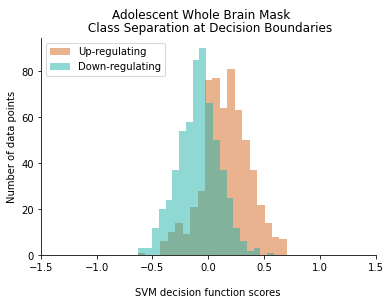

In [28]:
y_decision_score = metric_data['test_dfunc'][0]
y_t = metric_data['y_t'][0]
y_negative_decision_score = y_decision_score[y_t == 0]
y_positive_decision_score = y_decision_score[y_t == 1]


ax = plt.subplot()
# plot the two histograms
plt.hist(y_positive_decision_score, 
         bins = 20, 
         alpha=0.5, 
         label='Up-regulating', 
         #ls='dotted',
         #lw=.5, 
         color='chocolate', 
         histtype='bar', 
         #ec='olive'
         )
plt.hist(y_negative_decision_score, 
         bins = 20, 
         alpha=0.5, 
         label='Down-regulating',
         #ls='dotted', 
         #lw = .5, 
         color='lightseagreen', 
         histtype='bar', 
         #ec='gold'
         )
ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)
plt.xlim(-1.5, 1.5)
plt.legend(loc = "upper left")
plt.xlabel('\nSVM decision function scores')
plt.ylabel('Number of data points')
plt.suptitle("Adolescent Whole Brain Mask \n\n")
plt.title("\n Class Separation at Decision Boundaries")
plt.savefig('/content/gdrive/MyDrive/ADOL/AD_decision_hist.png', dpi=200, transparent=True)
plt.show()

## Predict Adolescent on Young Adult Model

In [ ]:
# get train, test val data
train_ids = ad[:23]
val_ids = ad[23:28]
test_ids = ad[28:34]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
model_type = "YA_YA_pscz"
data_type = "Adolescent_YA"
runs_id = [i+1 for i in runs_train]

print("Number of Adolescent training examples: ", len(train_ids))
print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(len(ad))

# Get the Data normalized and concatenated
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

# Load YA model and predict the Adol data
model_dict = access_load_data(f"models/group/{model_type}_{runs_id}_{mask_type}_X_y_model.pkl", False)
print(model_dict.keys())
clf = model_dict['model'][0]

# Analyze results
metrics(clf, X_v, y_v, X_t, y_t, data_type, runs_id, mask_type)

Number of Adolescent training examples:  23
Number of Adolescent validation examples:  5
Number of Adolescent testing examples:  5
33
Normalizing Each based on RUNS...
Final X Train data shape (3864, 237979)
Final y Train data shape  (3864,)
Final X Val data shape (840, 237979)
Final y Val data shape  (840,)
Final X Test data shape (840, 237979)
Final y Test data shape  (840,)
dict_keys(['model', 'X_train', 'y_train'])
Predicting on Validation set...
Validation Accuracy: 0.7214285714285714
Predicting on Test set...
Test Accuracy: 0.7345238095238096
upload complete for metrics/group_svm/Adolescent_YA_model_[2, 3]_whole_brain_validation_classreport.csv
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       420
           1       0.71      0.75      0.73       420

    accuracy                           0.72       840
   macro avg       0.72      0.72      0.72       840
weighted

True

> Fin